In [ ]:
print('running')
import os
import torch
from torch.utils.data import DataLoader
from joblib import dump
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from util import translate_img_batch, cross_entropy_loss_fn
from data import load_data
from train import evaluation
from sample_quality import calculate_kid
import statistics
import matplotlib.pyplot as plt
import yaml

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

_, _, test_data = load_data('mnist', binarize=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

result_dir = 'results_made/translation_lls'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = '1'
model = torch.load(result_dir + '/' + name + '.model').to(device)
model.eval()

translations = [(1,0,0,0), (0,1,0,0), (0,0,1,0), (0,0,0,1)] #, (1,1,0,0), (0,0,1,1), (2,1,0,0), (1,2,0,0), (0,0,1,2), (0,0,2,1), (2,2,0,0), (0,0,2,2)]
lls_translation = {}
for translation in translations:
    print(translation)
    shift_left, shift_down, shift_right, shift_up = translation
    lls = []
    for img in test_loader:
        translated_img = translate_img_batch(img, shift_left, shift_down, shift_right, shift_up)
        preds = model.forward(img)
        translated_preds = model.forward(translated_img)
        ll = -(cross_entropy_loss_fn(img, preds) - cross_entropy_loss_fn(translated_img, translated_preds))
        lls.append(ll)
    lls_translation[translation] = lls

with open(result_dir + f'{name}.pkl', 'wb') as file:
    dump(lls_translation, file)

translations_dic = {translation: None for translation in translations}
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, translation in enumerate(translations):
    values = [tensor.item() for tensor in lls_translation[translation]]
    translations_dic[translation] = {'mean': statistics.mean(values), 
                                     'absolute mean': sum([abs(x) for x in values])/len(values), 
                                     'std dev': statistics.stdev(values)}
    ax = axes[i // 2, i % 2]
    ax.hist(values, bins=50, edgecolor='black')
    ax.set_xlabel('Difference in Log-Likelihoods')
    ax.set_ylabel('Frequency')
    if i == 0:
        ax.set_title(f'Shift Left 1 Pixel')
    elif i == 1:
        ax.set_title(f'Shift Left 1 Pixel')
    elif i == 2:
        ax.set_title(f'Shift Right 1 Pixel')
    else:
        ax.set_title(f'Shift Up 1 Pixel')
    ax.grid(True)

with open('statistics_2.yaml', 'w') as file:
    yaml.dump(translations_dic, file)
print(translations_dic)

In [1]:
print('running')
import os
import torch
from torch.utils.data import DataLoader
from joblib import dump
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from util import translate_img_batch, cross_entropy_loss_fn
from data import load_data
from train import evaluation
from sample_quality import calculate_kid
import statistics
import matplotlib.pyplot as plt
import yaml

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

running


FINAL LOSS: nll=1.3704134735107423
test loss: 87.7064623046875


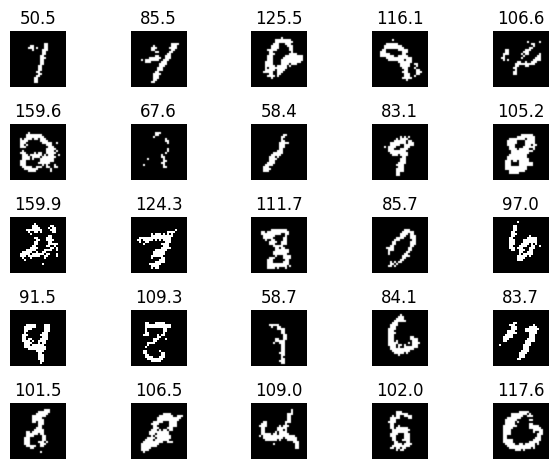

In [7]:
# Should be able to load models from the registry
# TODO: maybe store translation_lls and statistics as an artifact?

_, _, test_data = load_data('mnist', binarize=True) # Remove val_data
batch_size = 64
test_loader = DataLoader(test_data, batch_size=batch_size)

model = torch.load('models/made.model') # Change this to the one from model registry
model.eval()
test_loss = evaluation(test_loader, cross_entropy_loss_fn, model_best = model)
print(f"test loss: {test_loss * batch_size}")
x = model.sample(25)#.detach().numpy()
fig1, axes1 = plt.subplots(5, 5)
for i in range(25):
    ax = axes1[i // 5, i % 5]
    ax.imshow(x.detach().numpy()[i].reshape(28,28), cmap = 'gray')
    preds = model.forward(x[i])
    nll = cross_entropy_loss_fn(x[i], preds)
    ax.set_title(f"{round(nll.item(),1)}")
    ax.axis('off')
fig1.tight_layout()

In [ ]:
train_data, _, test_data = load_data('mnist', binarize=True, eval = True, val = False) # Remove val_data
train_loader = DataLoader(train_data, batch_size=1)
test_loader = DataLoader(test_data, batch_size=1)

train_images = next(iter(train_loader))
test_images = next(iter(test_loader))
kid = calculate_kid(train_images[:1], test_images[:1]) # Replace with samples
print(f"KID: {kid}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /Users/rajit906/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 39.5MB/s]


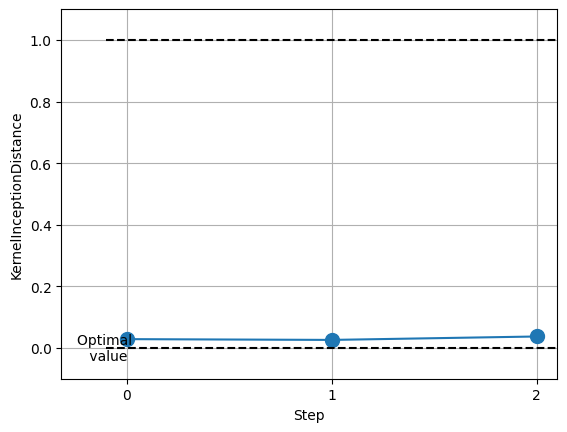

In [3]:
import torch
from torchmetrics.image.kid import KernelInceptionDistance
imgs_dist1 = lambda: torch.randint(0, 200, (30, 3, 299, 299), dtype=torch.uint8)
imgs_dist2 = lambda: torch.randint(100, 255, (30, 3, 299, 299), dtype=torch.uint8)
metric = KernelInceptionDistance(subsets=3, subset_size=20)
values = [ ]
for _ in range(3):
     metric.update(imgs_dist1(), real=True)
     metric.update(imgs_dist2(), real=False)
     values.append(metric.compute()[0])
     metric.reset()
fig_, ax_ = metric.plot(values)